In [1]:
import sys
import logging

import numpy as np
import scipy as sp
import sklearn

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("whitegrid")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D,Input,BatchNormalization,Reshape,MaxPooling2D
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder 

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from titanic.go1_utils import load_digit_data, process_digit_data, encode_labels

In [4]:

path= "../data/"
train,test,labels,sample_submission = load_digit_data(path)

In [5]:
len(labels.value_counts())

10

In [6]:
shape_flat = train.shape[1]
shape_full = (28,28,1)
num_classes = len(labels.value_counts())

In [7]:
# Create an input layer which is similar to a feed_dict in TensorFlow.
inputs = Input(shape=(shape_flat,))
#copy
net = inputs
# The input is an image as a flattened array with 784 elements.
# But the convolutional layers expect images with shape (28, 28, 1)
net = Reshape(shape_full)(net)
# First convolutional layer with ReLU-activation and max-pooling.
net = Conv2D(kernel_size=5,strides=1,filters=16,padding='same', 
             activation='relu',name='layer_conv1')(net)
net = MaxPooling2D(pool_size=2,strides=2)(net)
# Second convolutional layer with ReLU-activation and max-pooling.
net = Conv2D(kernel_size=5,strides=1,filters=36,padding='same', 
             activation='relu',name='layer_conv2')(net)
net = MaxPooling2D(pool_size=2,strides=2)(net)
# Flatten the output of the conv-layer from 4-dim to 2-dim.
net = Flatten()(net)
# First fully-connected / dense layer with ReLU-activation.
net = Dense(128,activation='relu')(net)
# Last fully-connected / dense layer with softmax-activation
# so it can be used for classification.
net = Dense(num_classes,activation='softmax')(net)
outputs=net

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
from tensorflow.python.keras.models import Model

In [9]:
model = Model(inputs,outputs)
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [10]:
train.shape,type(labels),labels.shape

((42000, 784), pandas.core.series.Series, (42000,))

In [11]:
import warnings

warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [18]:
lab_enc = encode_labels(labels)

image_data = process_digit_data(train).reshape(-1,784)
#lab_enc.shape,image_data.shape
X_train, X_test, y_train, y_test = train_test_split(image_data, lab_enc, test_size=0.1, random_state=42)

/home/robert/anaconda3/envs/nn_env/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:414: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [19]:
model.fit(X_train,y_train,epochs=1,batch_size=64)

Instructions for updating:
Use tf.cast instead.
37800/37800 [==============================] - 14s 361us/sample - loss: 0.1991 - acc: 0.9381


In [59]:
model.evaluate(X_test,y_test)

4200/4200 [==============================] - 2s 556us/sample - loss: 0.0574 - acc: 0.9819


[0.057404437519033395, 0.98190475]

In [20]:
import math


def plot_conv_weights(weights, input_channel=0):
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(weights)
    w_max = np.max(weights)

    # Number of filters used in the conv. layer.
    num_filters = weights.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = weights[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
    
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
layer_conv1 (Conv2D)         (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 14, 14, 36)        14436     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 36)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1764)              0         
__________

In [21]:
#The first convolutional layer has index 2.
layer_conv1=model.layers[2]
layer_conv2=model.layers[4]
#type(layer_conv1)
#get weights
weights_conv1 = layer_conv1.get_weights()[0]
weights_conv2 = layer_conv2.get_weights()[0]

In [22]:
weights_conv1.shape,weights_conv2.shape

((5, 5, 1, 16), (5, 5, 16, 36))

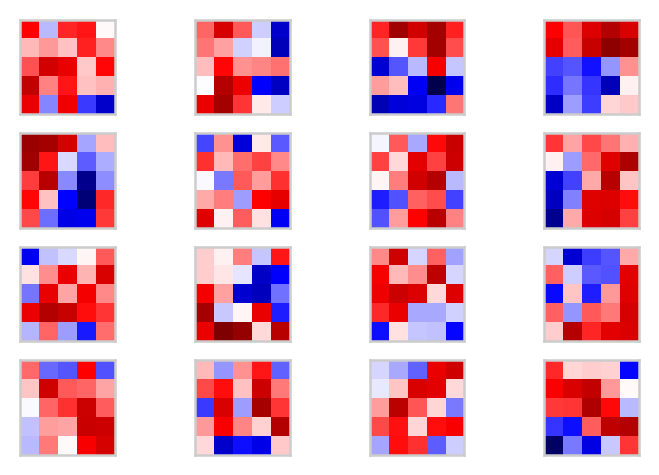

In [23]:
plot_conv_weights(weights=weights_conv1, input_channel=0)

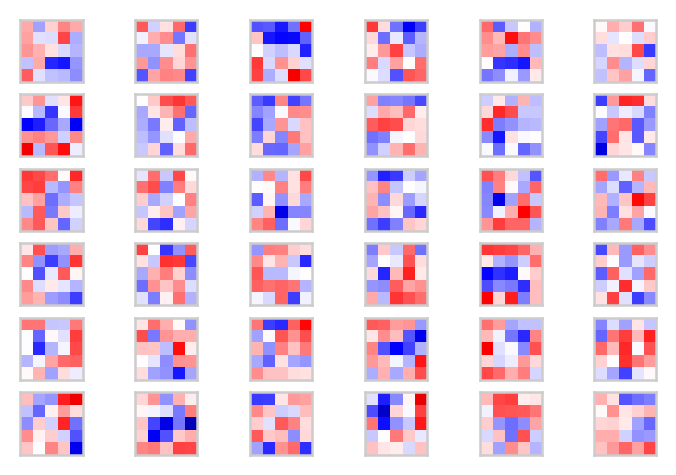

In [24]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

## on computing outputs of a conv layer-- see Magnus episode 3

In [25]:
%pdef plot_conv_weights

 plot_conv_weights(weights, input_channel=0)
 

In [26]:
%pinfo model

Signature:      model(inputs, *args, **kwargs)
Type:           Model
String form:    <tensorflow.python.keras.engine.training.Model object at 0x7fdad4d67a90>
File:           ~/anaconda3/envs/nn_env/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py
Docstring:     
`Model` groups layers into an object with training and inference features.

There are two ways to instantiate a `Model`:

1 - With the "functional API", where you start from `Input`,
you chain layer calls to specify the model's forward pass,
and finally you create your model from inputs and outputs:

```python
import tensorflow as tf

inputs = tf.keras.Input(shape=(3,))
x = tf.keras.layers.Dense(4, activation=tf.nn.relu)(inputs)
outputs = tf.keras.layers.Dense(5, activation=tf.nn.softmax)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
```

2 - By subclassing the `Model` class: in that case, you should define your
layers in `__init__` and you should implement the model's forward pass
in `call`.



In [27]:
z = np.random.normal(10,2,(3,3))

In [28]:
print(z)

[[12.68068203  9.22682475 13.33795422]
 [ 6.56817393  6.2060383   6.83369698]
 [10.25301398 10.78151582  5.39600201]]


In [29]:
%pprint

Pretty printing has been turned OFF


In [30]:
print(z)

[[12.68068203  9.22682475 13.33795422]
 [ 6.56817393  6.2060383   6.83369698]
 [10.25301398 10.78151582  5.39600201]]


In [35]:
%precision 2
print(z)

[[12.68  9.23 13.34]
 [ 6.57  6.21  6.83]
 [10.25 10.78  5.4 ]]


In [39]:
%precision 4
z=np.pi
print(z)

3.141592653589793


In [40]:
%psearch np.b*  

np.bartlett
np.base_repr
np.binary_repr
np.bincount
np.bitwise_and
np.bitwise_not
np.bitwise_or
np.bitwise_xor
np.blackman
np.block
np.bmat
np.bool
np.bool8
np.bool_
np.broadcast
np.broadcast_arrays
np.broadcast_to
np.busday_count
np.busday_offset
np.busdaycalendar
np.byte
np.byte_bounds
np.bytes0
np.bytes_

In [42]:
#help(np.bincount)
#%psource model
%who

BatchNormalization	 Conv2D	 Dense	 Dropout	 Flatten	 ImageDataGenerator	 Input	 LabelEncoder	 MaxPool2D	 
MaxPooling2D	 Model	 OneHotEncoder	 RMSprop	 Reshape	 StandardScaler	 X_test	 X_train	 confusion_matrix	 
encode_labels	 image_data	 inputs	 lab_enc	 labels	 layer_conv1	 layer_conv2	 load_digit_data	 logging	 
math	 model	 mpl	 net	 np	 num_classes	 outputs	 path	 pd	 
plot_conv_weights	 plt	 process_digit_data	 sample_submission	 shape_flat	 shape_full	 sklearn	 sns	 sp	 
sys	 test	 train	 train_test_split	 warnings	 weights_conv1	 weights_conv2	 y_test	 y_train	 
z	 


In [90]:
#%whos

Variable             Type          Data/Info
--------------------------------------------
BatchNormalization   type          <class 'tensorflow.python<...>on.BatchNormalizationV1'>
Conv2D               type          <class 'tensorflow.python<...>rs.convolutional.Conv2D'>
Dense                type          <class 'tensorflow.python<...>keras.layers.core.Dense'>
Dropout              type          <class 'tensorflow.python<...>ras.layers.core.Dropout'>
Flatten              type          <class 'tensorflow.python<...>ras.layers.core.Flatten'>
ImageDataGenerator   type          <class 'tensorflow.python<...>mage.ImageDataGenerator'>
Input                function      <function Input at 0x00000176E09FD048>
LabelEncoder         type          <class 'sklearn.preproces<...>sing.label.LabelEncoder'>
MaxPool2D            type          <class 'tensorflow.python<...>rs.pooling.MaxPooling2D'>
MaxPooling2D         type          <class 'tensorflow.python<...>rs.pooling.MaxPooling2D'>
Model            